Goal: We want to analyze range of overlap between source and target populations in feature age such that it ganrantees good performance on OTTEHR

In [1]:
import sys
import getpass
user_id = getpass.getuser()
sys.path.append(f"/home/{user_id}/OTTEHR/")

import matplotlib.pyplot as plt
from mimic_common import *
import numpy as np
import os
import pandas as pd

2024-12-05 17:17:18.213963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 17:17:18.214012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 17:17:18.215268: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 17:17:18.222117: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 17:17:18.972675: W tensorflow/compiler/tf2

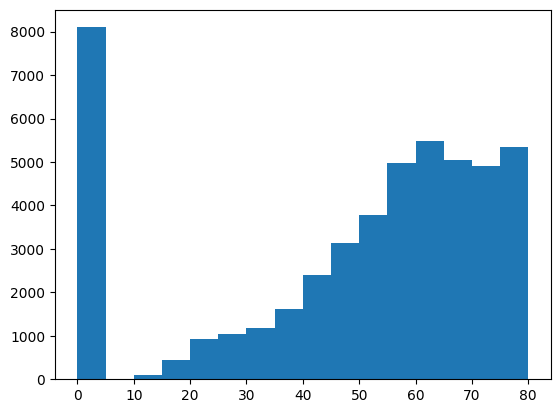

In [2]:
# Visualize age distribution 
mimic_iii_df = pd.read_csv(os.path.join(mimic_output_dir, 'admission_patient_diagnosis_ICD_with_age.csv'), index_col=None, header=0, converters={'ICD codes': literal_eval})

bins = np.arange(0, 81, 5)
plt.hist(mimic_iii_df['age'], bins=bins)
plt.show()

In [3]:
# Function to calculate overlap ratio
def calc_overlap(source, target):
    """ 
    Function to calculate the overlap ratio bewteen target range and source range
    """
    overlap = max(0, min(target[1], source[1]) - max(target[0], source[0]))
    total_range = source[1] - source[0]
    return overlap / total_range

In [7]:
source_range = [50, 70]
target_ranges = [[15, 30], [20, 35], [25, 40], [30, 45], [35, 50], [40, 55], [45, 60], [50, 65], [55, 70], [60, 75], [65, 80]]
group_name = 'age'
trans_metric = 'OT'
mae_stats = []
rmse_stats = []

for target_range in target_ranges:
    score_path = os.path.join(mimic_output_dir, f"{group_name}_{target_range}_to_{source_range}_{trans_metric}.csv")
    score_df = pd.read_csv(score_path, header=0, index_col=None)
    mae_stats.append(np.mean(score_df['trans_target_mae'])) 
    rmse_stats.append(np.mean(score_df['trans_target_rmse']))


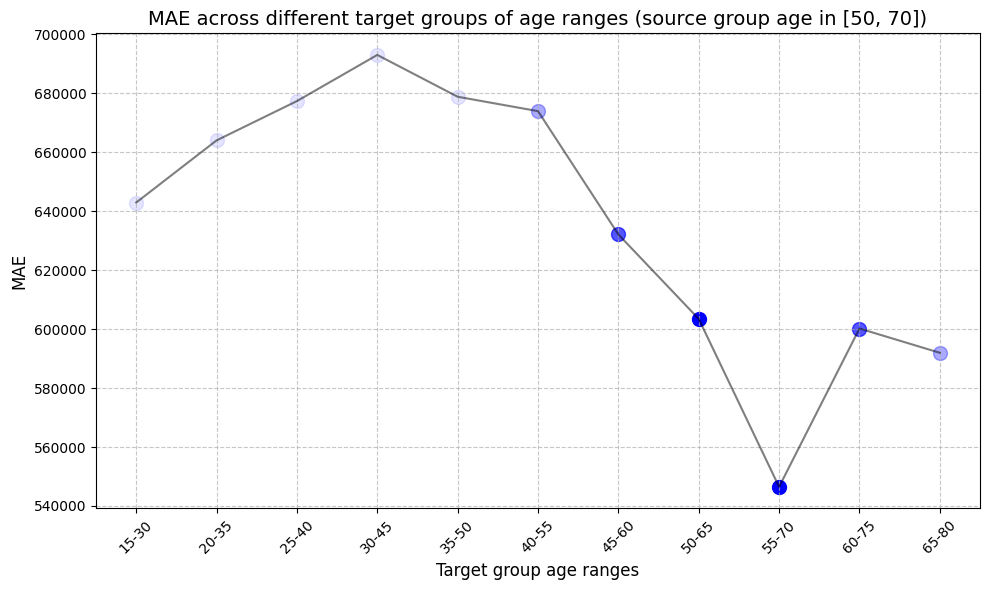

In [14]:
# Investigate MAE robustness

# Calculate overlap ratios for each target range
overlap_ratios = [calc_overlap(target, source_range) for target in target_ranges]
for i, item in enumerate(overlap_ratios):
    if item == 0:
        overlap_ratios[i] = 0.1

# Convert target ranges into a readable format for visualization
target_range_labels = [f"{r[0]}-{r[1]}" for r in target_ranges]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(target_range_labels, mae_stats, color='black', linestyle='-', alpha=0.5, label="Connecting Line")
for i, (label, mae, overlap) in enumerate(zip(target_range_labels, mae_stats, overlap_ratios)):
    plt.scatter(label, mae, color='blue', alpha=overlap, s=100)

# Add labels, title, and grid
plt.xlabel("Target group age ranges", fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.title("MAE across different target groups of age ranges (source group age in [50, 70])", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)


# Show the plot
plt.tight_layout()
fig_path = os.path.join(mimic_output_dir, "age_MAE_robustness.pdf")
plt.savefig(fig_path)

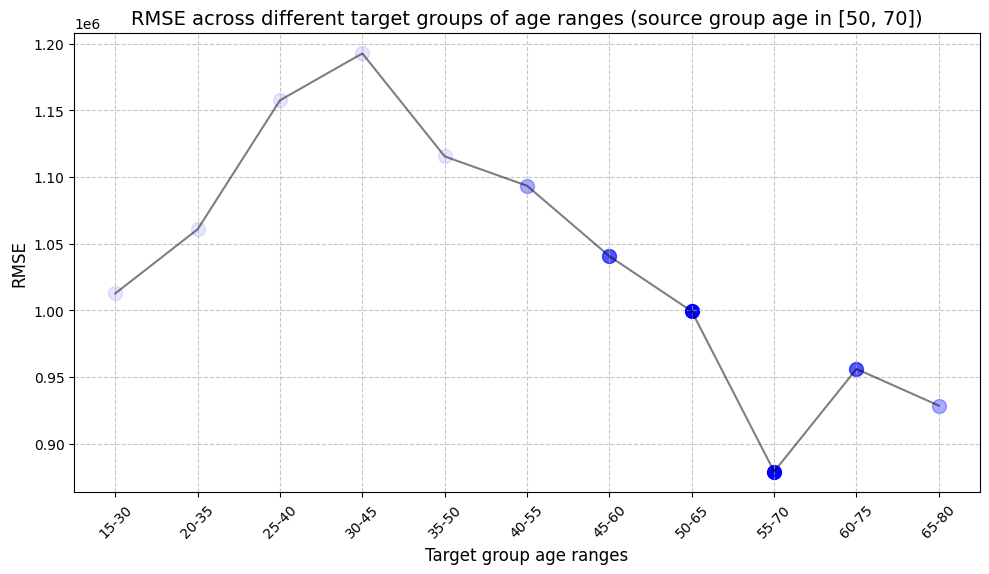

In [15]:
# Investigate RMSE robustness


# Convert target ranges into a readable format for visualization
target_range_labels = [f"{r[0]}-{r[1]}" for r in target_ranges]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(target_range_labels, rmse_stats, color='black', linestyle='-', alpha=0.5, label="Connecting Line")
for i, (label, rmse, overlap) in enumerate(zip(target_range_labels, rmse_stats, overlap_ratios)):
    plt.scatter(label, rmse, color='blue', alpha=overlap, s=100)

# Add labels, title, and grid
plt.xlabel("Target group age ranges", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title("RMSE across different target groups of age ranges (source group age in [50, 70])", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
fig_path = os.path.join(mimic_output_dir, "age_RMSE_robustness.pdf")
plt.savefig(fig_path)